In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

# Kalman Filter Implementation for Constant Acceleration Model (CA) in Python

Situation covered: You have an acceleration sensor (in 2D: $\ddot x$ and $\ddot y$) and try to calculate velocity ($\dot x$ and $\dot y$) as well as position ($x$ and $y$) of a person holding a smartphone in his/her hand.

![Smartphone](http://farm8.staticflickr.com/7324/12470549875_d562b39f52.jpg)

unter CC BY-NC 2.0 von flickr.com von Canadian Pacific

## State Vector - Constant Acceleration

Constant Acceleration Model for Ego Motion in Plane

$$x= \left[ \matrix{ x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y} \right]$$



Formal Definition:

$$x_{k+1} = A \cdot x_{k} + B \cdot u$$

Hence, we have no control input $u$:

$$x_{k+1} = \begin{bmatrix}1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 & 0 \\ 0 & 1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 \\ 0 & 0 & 1 & 0 & \Delta t & 0 \\ 0 & 0 & 0 & 1 & 0 & \Delta t \\ 0 & 0 & 0 & 0 & 1 & 0  \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y\end{bmatrix}_{k}$$

$$y = H \cdot x$$

Just the acceleration ($\ddot x$ & $\ddot y$) is measured.

$$y = \begin{bmatrix}0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix} \cdot x$$

#### Initial State

(matrix([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]), (6, 1))


/Users/paul/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


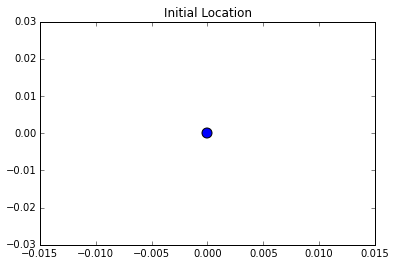

In [2]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)
n=x.size # States
plt.scatter(float(x[0]),float(x[1]), s=100)
plt.title('Initial Location')

#### Initial Uncertainty

(matrix([[ 10.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  10.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  10.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  10.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  10.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  10.]]), (6, 6))


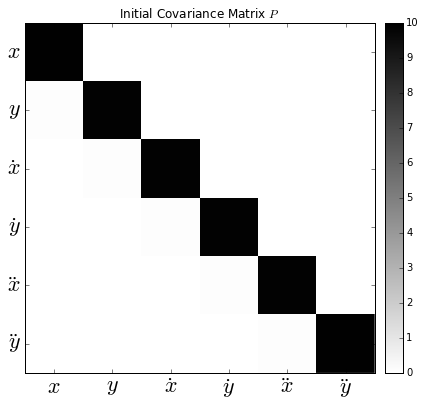

In [3]:
P = np.matrix([[10.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 10.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 10.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 10.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 10.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 10.0]])
print(P, P.shape)


fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

## Dynamic Matrix

It is calculated from the dynamics of the Egomotion.

$$x_{k+1} = x_{k} + \dot x_{k} \cdot \Delta t +  \ddot x_k \cdot \frac{1}{2}\Delta t^2$$
$$y_{k+1} = y_{k} + \dot y_{k} \cdot \Delta t +  \ddot y_k \cdot \frac{1}{2}\Delta t^2$$

$$\dot x_{k+1} = \dot x_{k} + \ddot x \cdot \Delta t$$
$$\dot y_{k+1} = \dot y_{k} + \ddot y \cdot \Delta t$$

$$\ddot x_{k+1} = \ddot x_{k}$$
$$\ddot y_{k+1} = \ddot y_{k}$$

In [4]:
dt = 0.5 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, dt, 0.0, 1/2.0*dt**2, 0.0],
              [0.0, 1.0, 0.0, dt, 0.0, 1/2.0*dt**2],
              [0.0, 0.0, 1.0, 0.0, dt, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

(matrix([[ 1.   ,  0.   ,  0.5  ,  0.   ,  0.125,  0.   ],
        [ 0.   ,  1.   ,  0.   ,  0.5  ,  0.   ,  0.125],
        [ 0.   ,  0.   ,  1.   ,  0.   ,  0.5  ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.5  ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ]]), (6, 6))


## Measurement Matrix

Here you can determine, which of the states is covered by a measurement. In this example, the position ($x$ and $y$) as well as the acceleration is measured ($\ddot x$ and $\ddot y$).

In [5]:
H = np.matrix([[0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

(matrix([[ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]]), (2, 6))


## Measurement Noise Covariance

(matrix([[ 100.,    0.],
        [   0.,  100.]]), (2, 2))


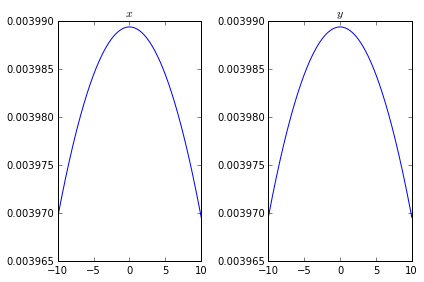

In [6]:
ra = 10.0**2
R = np.matrix([[ra, 0.0],
               [0.0, ra]])
print(R, R.shape)

# Plot between -10 and 10 with .001 steps.
xpdf = np.arange(-10, 10, 0.001)
plt.subplot(121)
plt.plot(xpdf, norm.pdf(xpdf,0,R[0,0]))
plt.title('$x$')

plt.subplot(122)
plt.plot(xpdf, norm.pdf(xpdf,0,R[1,1]))
plt.title('$y$')


plt.tight_layout()

## Process Noise Covariance Matrix Q for CA Model

The Position of an object can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). This process noise has to be modeled with the process noise covariance matrix Q.

$$Q = \begin{bmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} & \sigma_{x \ddot x} & \sigma_{x \ddot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} & \sigma_{y \ddot x} & \sigma_{y \ddot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} & \sigma_{\dot x \ddot x} & \sigma_{\dot x \ddot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 & \sigma_{\dot y \ddot x} & \sigma_{\dot y \ddot y} \\ \sigma_{\ddot x x} & \sigma_{\ddot x y} & \sigma_{\ddot x \dot x} & \sigma_{\ddot x \dot y} & \sigma_{\ddot x}^2 & \sigma_{\ddot x \ddot y} \\ \sigma_{\ddot y x} & \sigma_{\ddot y y} & \sigma_{\ddot y \dot x} & \sigma_{\ddot y \dot y} & \sigma_{\ddot y \ddot x} & \sigma_{\ddot y}^2\end{bmatrix}$$

To easily calcualte Q, one can ask the question: How the noise effects my state vector? For example, how the acceleration change the position over one timestep dt.

One can calculate Q as

$$Q = G\cdot G^T \cdot \sigma_a^2$$

with $G = \begin{bmatrix}0.5dt^2 & 0.5dt^2 & dt & dt & 1.0 & 1.0\end{bmatrix}^T$ and $\sigma_a$ as the acceleration process noise.

#### Symbolic Calculation

In [7]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing(use_latex=True)
dts = Symbol('\Delta t')
Qs = Matrix([[0.5*dts**2],[0.5*dts**2],[dts],[dts],[1.0],[1.0]])
Qs*Qs.T

⎡             4               4              3              3              2  
⎢0.25⋅\Delta t   0.25⋅\Delta t   0.5⋅\Delta t   0.5⋅\Delta t   0.5⋅\Delta t   
⎢                                                                             
⎢             4               4              3              3              2  
⎢0.25⋅\Delta t   0.25⋅\Delta t   0.5⋅\Delta t   0.5⋅\Delta t   0.5⋅\Delta t   
⎢                                                                             
⎢            3               3             2              2                   
⎢0.5⋅\Delta t    0.5⋅\Delta t      \Delta t       \Delta t     1.0⋅\Delta t   
⎢                                                                             
⎢            3               3             2              2                   
⎢0.5⋅\Delta t    0.5⋅\Delta t      \Delta t       \Delta t     1.0⋅\Delta t   
⎢                                                                             
⎢            2               2                      

In [8]:
sa = 0.1
G = np.matrix([[1/2.0*dt**2],
               [1/2.0*dt**2],
               [dt],
               [dt],
               [1.0],
               [1.0]])
Q = G*G.T*sa**2

print(Q, Q.shape)

(matrix([[ 0.00015625,  0.00015625,  0.000625  ,  0.000625  ,  0.00125   ,
          0.00125   ],
        [ 0.00015625,  0.00015625,  0.000625  ,  0.000625  ,  0.00125   ,
          0.00125   ],
        [ 0.000625  ,  0.000625  ,  0.0025    ,  0.0025    ,  0.005     ,
          0.005     ],
        [ 0.000625  ,  0.000625  ,  0.0025    ,  0.0025    ,  0.005     ,
          0.005     ],
        [ 0.00125   ,  0.00125   ,  0.005     ,  0.005     ,  0.01      ,
          0.01      ],
        [ 0.00125   ,  0.00125   ,  0.005     ,  0.005     ,  0.01      ,
          0.01      ]]), (6, 6))


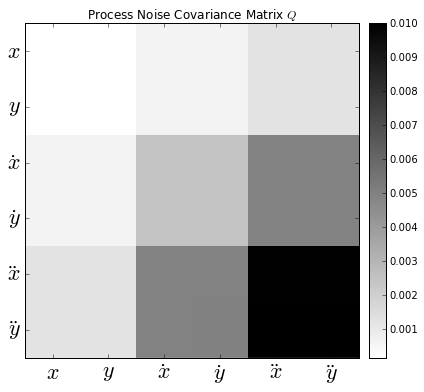

In [9]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

## Identity Matrix

In [10]:
I = np.eye(n)
print(I, I.shape)

(array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]]), (6, 6))


## Measurement

They are generated synthetically

In [11]:
m = 100 # Measurements

# Acceleration
sa= 0.1 # Sigma for acceleration
ax= 0.0 # in X
ay= 0.0 # in Y

mx = np.array(ax+sa*np.random.randn(m))
my = np.array(ay+sa*np.random.randn(m))

measurements = np.vstack((mx,my))

print(measurements.shape)
print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mx))
print('You assumed %.2f in R.' % R[0,0])

(2, 100)
Standard Deviation of Acceleration Measurements=0.09
You assumed 100.00 in R.


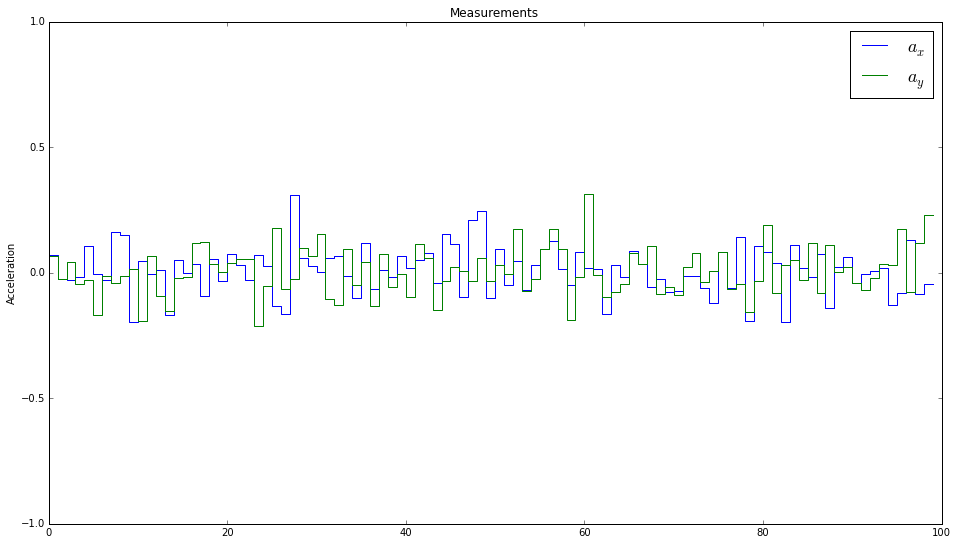

In [12]:
fig = plt.figure(figsize=(16,9))
plt.step(range(m),mx, label='$a_x$')
plt.step(range(m),my, label='$a_y$')
plt.ylabel('Acceleration')
plt.title('Measurements')
plt.ylim([-1, 1])
plt.legend(loc='best',prop={'size':18})
plt.savefig('Kalman-Filter-CA-Measurements.png', dpi=72, transparent=True, bbox_inches='tight')

In [13]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
ddxt=[]
ddyt=[]
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kddy=[]

## Kalman Filter

![Kalman Filter](https://raw.github.com/balzer82/Kalman/master/Kalman-Filter-Step.png)

In [14]:
for n in range(m):
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q    
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(H.shape[0],1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P

   
    
    # Save states for Plotting
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    ddxt.append(float(x[4]))
    ddyt.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pddy.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kddy.append(float(K[5,0]))

## Plots

### Uncertainty

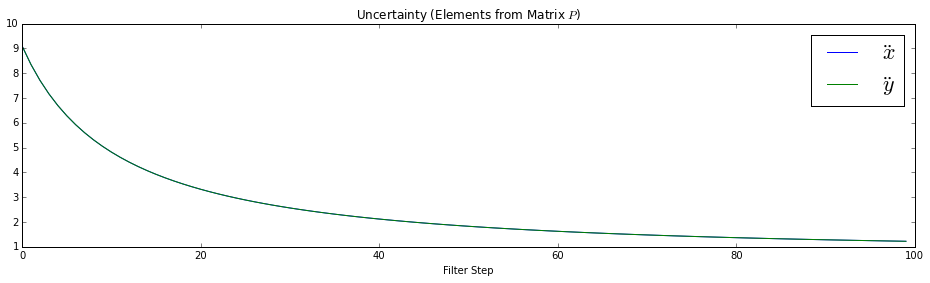

In [15]:
fig = plt.figure(figsize=(16,4))
#plt.plot(range(len(measurements[0])),Px, label='$x$')
#plt.plot(range(len(measurements[0])),Py, label='$y$')
plt.plot(range(len(measurements[0])),Pddx, label='$\ddot x$')
plt.plot(range(len(measurements[0])),Pddy, label='$\ddot y$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

### Kalman Gains

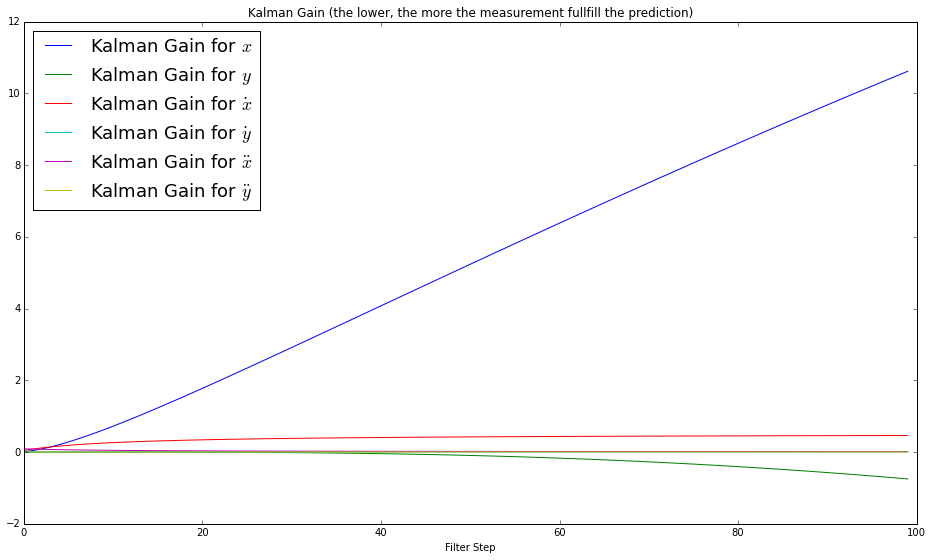

In [16]:
fig = plt.figure(figsize=(16,9))
plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')
plt.plot(range(len(measurements[0])),Kddx, label='Kalman Gain for $\ddot x$')
plt.plot(range(len(measurements[0])),Kddy, label='Kalman Gain for $\ddot y$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(loc='best',prop={'size':18})

### Covariance Matrix

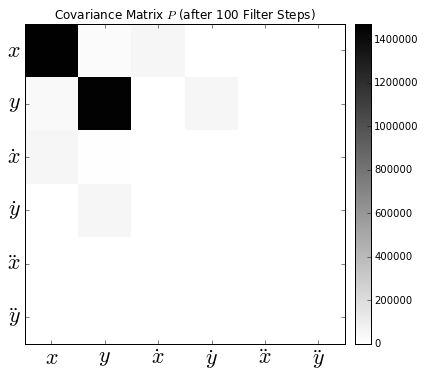

In [17]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filter Steps)' % (m))
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()
plt.savefig('Kalman-Filter-CA-CovarianceMatrix.png', dpi=72, transparent=True, bbox_inches='tight')

## State Vector

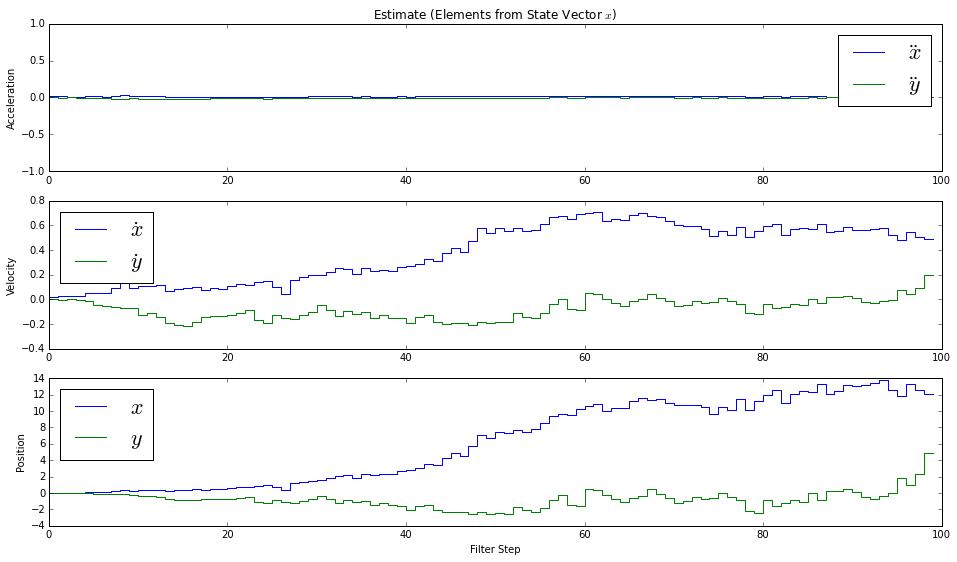

In [18]:
fig = plt.figure(figsize=(16,9))

plt.subplot(311)
plt.step(range(len(measurements[0])),ddxt, label='$\ddot x$')
plt.step(range(len(measurements[0])),ddyt, label='$\ddot y$')

plt.title('Estimate (Elements from State Vector $x$)')
plt.legend(loc='best',prop={'size':22})
plt.ylabel('Acceleration')
plt.ylim([-1,1])

plt.subplot(312)
plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
plt.step(range(len(measurements[0])),dyt, label='$\dot y$')

plt.ylabel('')
plt.legend(loc='best',prop={'size':22})
plt.ylabel('Velocity')
           
plt.subplot(313)
plt.step(range(len(measurements[0])),xt, label='$x$')
plt.step(range(len(measurements[0])),yt, label='$y$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':22})
plt.ylabel('Position')
plt.savefig('Kalman-Filter-CA-StateEstimated.png', dpi=72, transparent=True, bbox_inches='tight')

## Position x/y

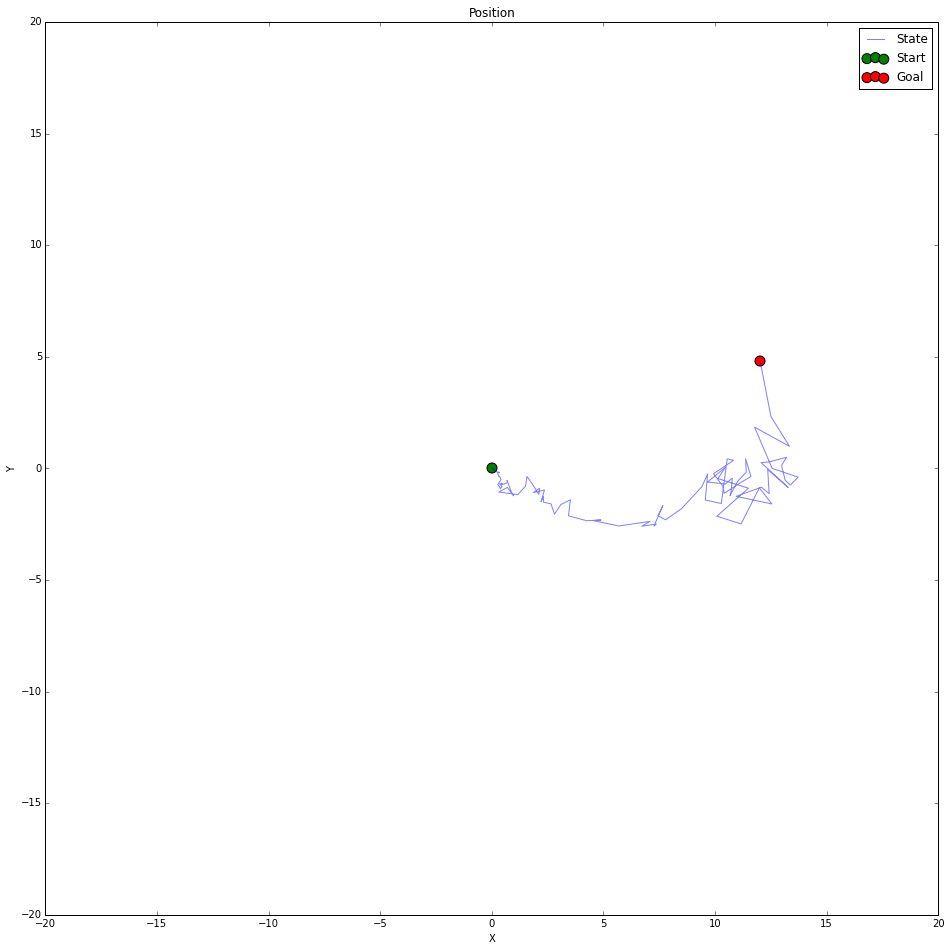

In [19]:
fig = plt.figure(figsize=(16,16))
plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')
plt.plot(xt,yt, label='State',alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position')
plt.legend(loc='best')
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.savefig('Kalman-Filter-CA-Position.png', dpi=72, transparent=True, bbox_inches='tight')

# Conclusion

In [20]:
dist=np.cumsum(np.sqrt(np.diff(xt)**2 + np.diff(yt)**2))
print('Your drifted %d units from origin.' % dist[-1])

Your drifted 62 units from origin.


As you can see, bad idea just to measure the acceleration and try to get the position. The errors integrating up, so your position estimation is drifting.